## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [154]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
#%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from random import sample
import scipy
import tensorflow as tf
from skimage import io

import sklearn as sk
import sklearn.model_selection as skl
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [155]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
77542,00019058_005.png,No Finding,5,19058,59,F,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00019058_005.png
69946,00017236_028.png,Atelectasis|Infiltration,28,17236,46,M,PA,2992,2985,0.143,0.143,NaN,/data/images_008/images/00017236_028.png
11499,00003028_002.png,No Finding,2,3028,57,F,PA,2426,2991,0.143,0.143,NaN,/data/images_002/images/00003028_002.png


In [156]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels({}):{}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)  

All Labels(15):['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
96911,00025548_000.png,Mass,0,25548,61,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13226,00003438_000.png,No Finding,0,3438,6,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19418,00005147_000.png,No Finding,0,5147,33,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [157]:
all_xray_df['Pneumonia_class'] = ['Pneumonia' if x==1 else 'No Pneumonia' for x in all_xray_df['Pneumonia']]
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
31055,00008068_009.png,Consolidation|Edema|Infiltration|Nodule,9,8068,41,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,No Pneumonia
20627,00005521_000.png,Atelectasis,0,5521,29,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
111078,00030323_005.png,Effusion|Infiltration|Pleural_Thickening,5,30323,31,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,No Pneumonia


In [158]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification



## Create your training and testing data:

In [159]:
#def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
   
    #return train_data, val_data

In [160]:
  train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [161]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [162]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

In [163]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [164]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [165]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [166]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [167]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    return val_gen

In [168]:
IMG_SIZE = (224, 224)

In [186]:
my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1) ## Here I'm adding a lot more zoom 

train_gen = my_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 120
                                         )

val_gen = my_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 120)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


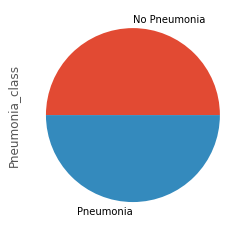

In [187]:
plt.figure(figsize=(4,4))
train_df['Pneumonia_class'].value_counts()[0:2].plot(kind='pie')

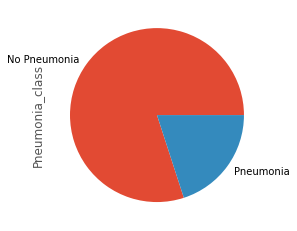

In [188]:
valid_df['Pneumonia_class'].value_counts()[0:2].plot(kind='pie')

In [189]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

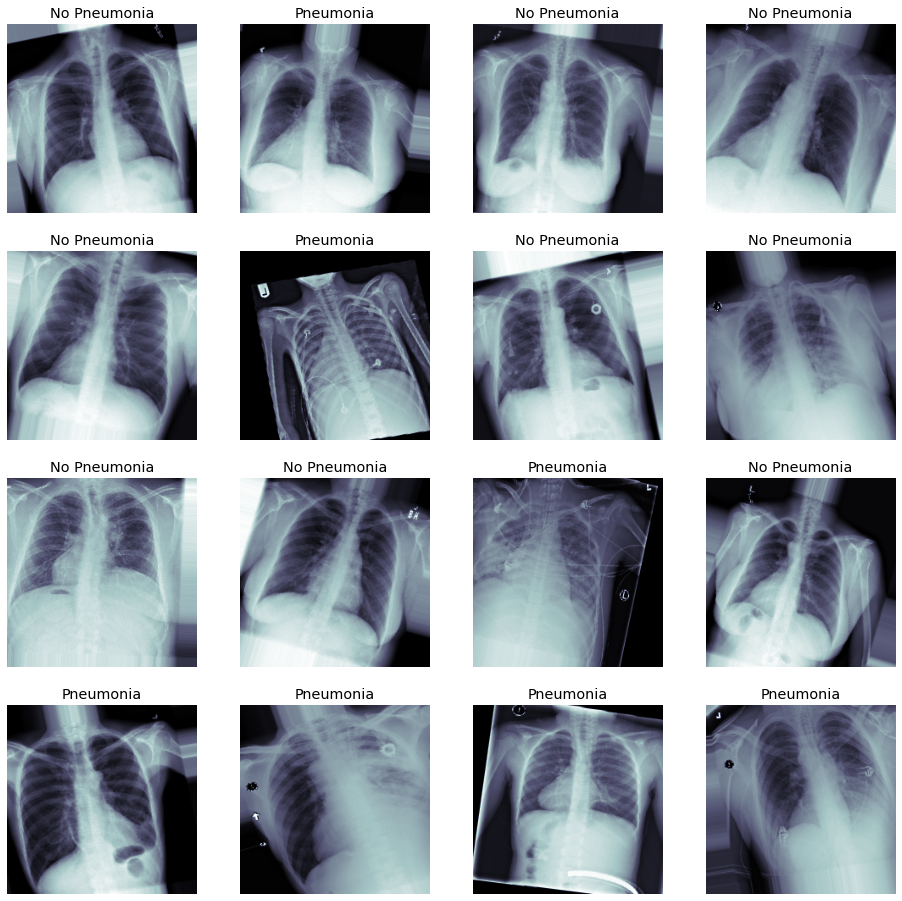

In [190]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [191]:
#def load_pretrained_model(vargs):
    
    #model = VGG16(include_top=True, weights='imagenet')
    #transfer_layer = model.get_layer('lay_of_interest')
    #vgg_model= Model(inputs = model.input, outputs = transfer_layer.output)
    
   #TODO
    
    #return vgg_model


In [192]:
model = VGG16(include_top=True, weights='imagenet')
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [193]:
#def build_my_model(vargs):
    
    #my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    #return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [194]:
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))
    

In [195]:
my_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)              

In [196]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

In [197]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "min", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "min", 
                      patience=10)

callbacks_list = [checkpoint, early]

In [198]:
weight_path

'xray_class_my_model.best.hdf5'

In [199]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [200]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training! 

In [201]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
20/20 [==============================] - 60s 3s/step - loss: 0.7824 - binary_accuracy: 0.5109 - val_loss: 0.7079 - val_binary_accuracy: 0.3750

Epoch 00001: val_loss improved from inf to 0.70786, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
20/20 [==============================] - 58s 3s/step - loss: 0.7250 - binary_accuracy: 0.5218 - val_loss: 0.6671 - val_binary_accuracy: 0.6833

Epoch 00002: val_loss improved from 0.70786 to 0.66713, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
20/20 [==============================] - 57s 3s/step - loss: 0.7029 - binary_accuracy: 0.5493 - val_loss: 0.6434 - val_binary_accuracy: 0.7667

Epoch 00003: val_loss improved from 0.66713 to 0.64338, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
20/20 [==============================] - 57s 3s/step - loss: 0.7054 - binary_accuracy: 0.5476 - val_loss: 0.6070 - val_binary_accuracy: 0.7833

Epoch 00004: val_loss improved from 0.64338 to 0.60699, saving model to xray_c

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [202]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 120, verbose = True)

120/120 [==============================] - 1s 10ms/step


In [203]:
pred_Y

array([[0.46568295],
       [0.5013785 ],
       [0.4831444 ],
       [0.45781767],
       [0.46101663],
       [0.48338342],
       [0.35600188],
       [0.41121435],
       [0.4488069 ],
       [0.45253745],
       [0.46148336],
       [0.47261286],
       [0.44486088],
       [0.44486985],
       [0.42747068],
       [0.3988681 ],
       [0.36782244],
       [0.50797266],
       [0.46561453],
       [0.45755866],
       [0.36782265],
       [0.45002654],
       [0.43973908],
       [0.42753956],
       [0.43416122],
       [0.43285665],
       [0.50033003],
       [0.39134914],
       [0.49372768],
       [0.4002378 ],
       [0.43211335],
       [0.47616228],
       [0.43527737],
       [0.5056183 ],
       [0.47921813],
       [0.3157981 ],
       [0.48758253],
       [0.46203634],
       [0.39843547],
       [0.36330387],
       [0.43005672],
       [0.3757458 ],
       [0.48508185],
       [0.48858765],
       [0.38554505],
       [0.40021253],
       [0.3987719 ],
       [0.314

In [204]:
valY

array([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0.], dtype=float32)

In [205]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

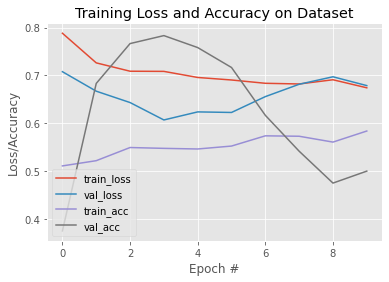

In [206]:
plot_history(history)

# Todo

In [207]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
   
    # Todo
    return

In [208]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    

In [209]:
plt.rcParams.update({'figure.max_open_warning': 0})

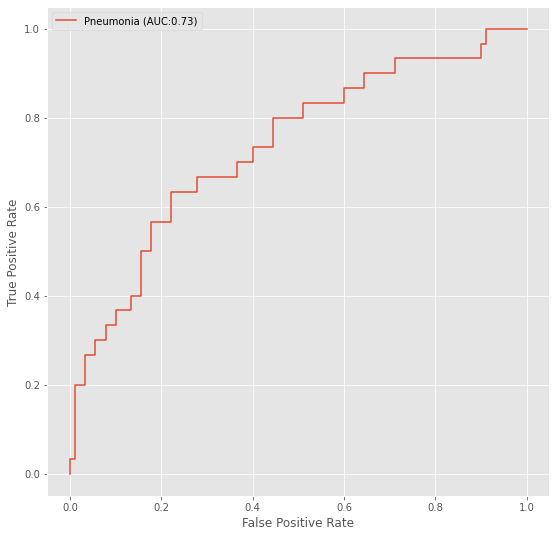

In [210]:
plot_auc(valY, pred_Y)

In [211]:
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


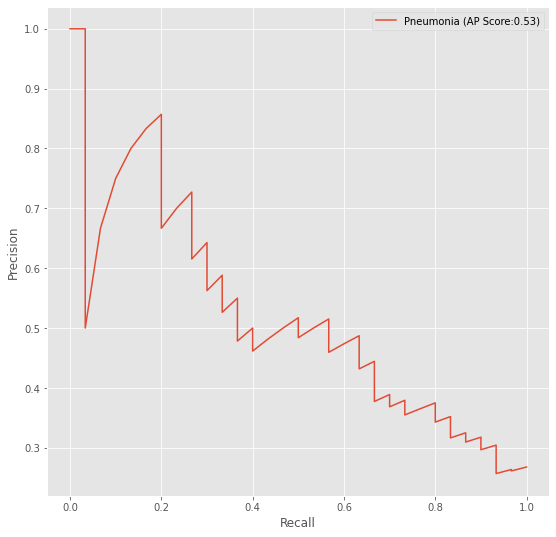

In [212]:
plot_pr(valY, pred_Y)

In [213]:
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

In [214]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [215]:
def plot_f1s(valY,pred_y):
        
    precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
    f1_scores = []
    for i in thresholds:
        f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
        f1_scores.append(f1)
    fig, c_ax = plt.subplots(1,1, figsize = (10, 10))
    c_ax.plot(thresholds, f1_scores, label = 'F1 Score')
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1 Score')

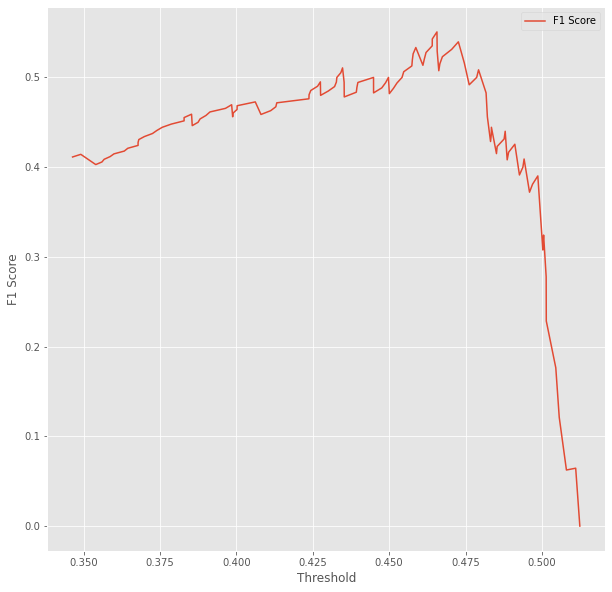

In [216]:
plot_f1s(valY, pred_Y)

In [217]:
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)

In [218]:
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.8
Recall is: 0.13333333333333333
Threshold is: 0.5044894
F1 Score is: 0.2285714285714286


In [219]:
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.34285714285714286
Recall is: 0.8
Threshold is: 0.43005672
F1 Score is: 0.48000000000000004


In [220]:
probs = pred_Y
t1 = (probs > 0.50)
t2 = (probs > 0.43)

In [221]:
x1 = np.asarray(t1).astype(int)
x2 = np.asarray(t2).astype(int)

In [222]:
x1

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [223]:
x1.ndim

2

In [224]:
x1=x1.flatten()

In [225]:
x2=x2.flatten()

In [226]:
 x1=pd.Series(x1)

In [227]:
 x2=pd.Series(x2)

In [228]:
x1

0      0
1      1
2      0
3      0
4      0
      ..
115    0
116    0
117    0
118    0
119    0
Length: 120, dtype: int64

In [229]:
compare_t1 = (x1 == valY)
compare_t2 = (x2 == valY)

In [230]:
compare_t1

0      False
1       True
2      False
3       True
4      False
       ...  
115     True
116     True
117     True
118     True
119     True
Length: 120, dtype: bool

In [231]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(pred_Y)))

Accuracy at threshold 1: 0.7833333333333333


In [232]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(pred_Y)))

Accuracy at threshold 2: 0.5666666666666667


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

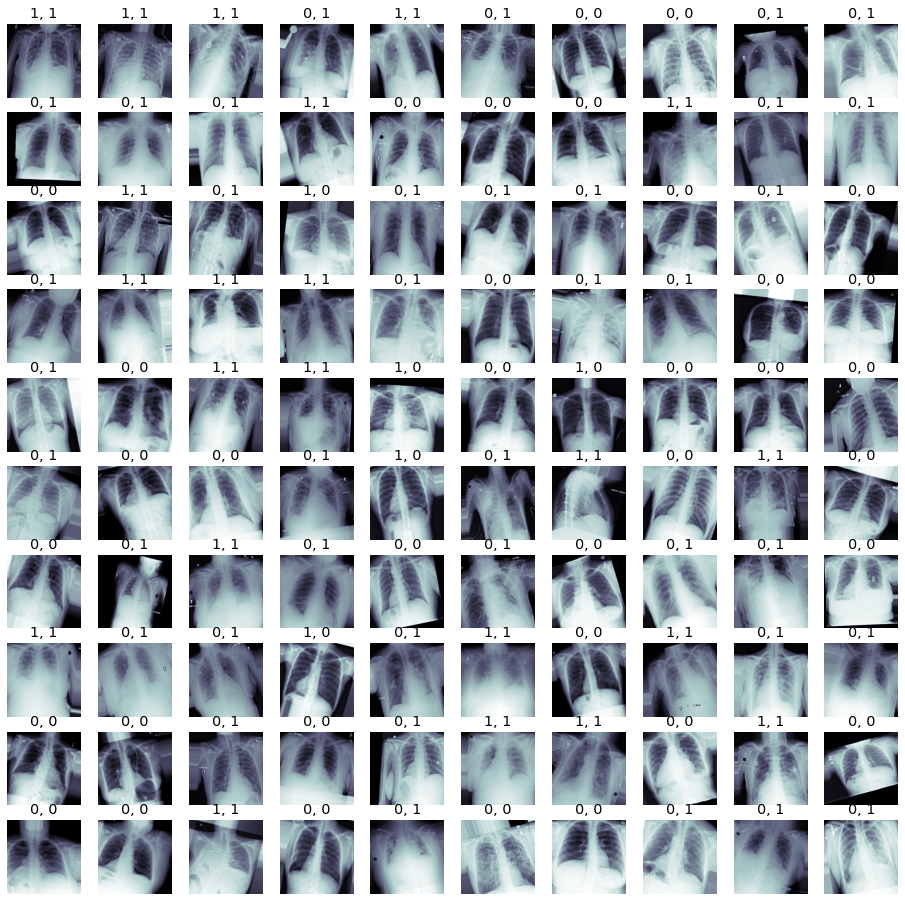

In [233]:
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.43:
            c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.43: 
            c_ax.set_title('0, 1')
        else:
             c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [235]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)